In [280]:
%matplotlib inline
import nibabel as nib
img = nib.load('/Users/hellwalker/Desktop/scans/614/Pre_Run1/brnswktm_functional_4.nii.gz')
img_data = img.get_data()
img_data.shape

(96, 114, 96, 600)

In [281]:
#uses AFNI mask to get masked voxels
def get_masked_voxels(mask_data):
    masked_voxels = []
    for x in range(0, mask_data.shape[0]):
        for y in range(0, mask_data.shape[1]):
            for z in range(0, mask_data.shape[2]):
                if mask_data[x, y, z] != 0:
                    masked_voxels.append((x, y, z))
    return masked_voxels

In [282]:
stim_site_mask = nib.load('/Users/hellwalker/Desktop/scans/stim_site_614.nii.gz')
stim_site_mask_data = stim_site_mask.get_data()
#stim_site_mask_data.shape
sphere_voxels = get_masked_voxels(stim_site_mask_data)
all_voxels = [list(voxel) for voxel in sphere_voxels]
#print(all_voxels)

In [283]:
"""
#todo: ignore voxels with 0.
sphere_size = 3 #3 voxels in all directions
epicenter = [59, -56, 47]
all_voxels = []#list of lists, with each list being 3D coordinate in sphere
for i in range(-sphere_size, sphere_size+1):
    for j in range(-sphere_size, sphere_size+1):
         for k in range(-sphere_size, sphere_size+1):
                new_voxel = [epicenter[0]+i, epicenter[1]+j, epicenter[2]+k]
                all_voxels.append(new_voxel)
"""

'\n#todo: ignore voxels with 0.\nsphere_size = 3 #3 voxels in all directions\nepicenter = [59, -56, 47]\nall_voxels = []#list of lists, with each list being 3D coordinate in sphere\nfor i in range(-sphere_size, sphere_size+1):\n    for j in range(-sphere_size, sphere_size+1):\n         for k in range(-sphere_size, sphere_size+1):\n                new_voxel = [epicenter[0]+i, epicenter[1]+j, epicenter[2]+k]\n                all_voxels.append(new_voxel)\n'

In [284]:
import copy
import numpy as np
#averaging over all voxels in sphere for every time point
def get_avg_each_timepoint(all_voxels, img_data):
    avg_each_timepoint = []
    for t in range(0, img_data.shape[3]):
        all_voxels_copy = copy.deepcopy(all_voxels)
        [all_voxels_copy[voxel].append(t) for voxel in range(0, len(all_voxels_copy))]
        all_data = [img_data[one_voxel[0], one_voxel[1], one_voxel[2], one_voxel[3]] for one_voxel in all_voxels_copy]
        avg = np.average(all_data)
        avg_each_timepoint.append(avg)
    return avg_each_timepoint
avg_each_timepoint = get_avg_each_timepoint(all_voxels, img_data)

In [285]:
import nibabel as nib
mask = nib.load('/Users/hellwalker/Desktop/scans/Morel_Mask_LPI_2mm.nii.gz')
mask_data = mask.get_data()
mask_data.shape

(96, 114, 96)

In [286]:
thalamus_voxels = get_masked_voxels(mask_data)

In [287]:
import scipy as sp
from scipy import stats
def get_correlation_dict(thalamus_voxels, img_data):
    correlation_dict = {} #thalamus_voxel:correlation between avg_each_timepoint and activity_vector, for finding max activity thalamus voxel
    for thalamus_voxel in thalamus_voxels:
        activity_vector = []
        for t in range(0, img_data.shape[3]):
            activity = img_data[thalamus_voxel[0], thalamus_voxel[1], thalamus_voxel[2], t]
            activity_vector.append(activity)
        correlation_dict[thalamus_voxel] = sp.stats.pearsonr(avg_each_timepoint, activity_vector)[0]
    return correlation_dict
correlation_dict = get_correlation_dict(thalamus_voxels, img_data)

In [288]:
def get_best_thalamus_voxel(correlation_dict):
    best_thalamus_voxel = max(correlation_dict, key=lambda x: correlation_dict[x])
    return best_thalamus_voxel
best_thalamus_voxel = get_best_thalamus_voxel(correlation_dict)
print(best_thalamus_voxel, correlation_dict[best_thalamus_voxel])

(36, 54, 33) 0.49339


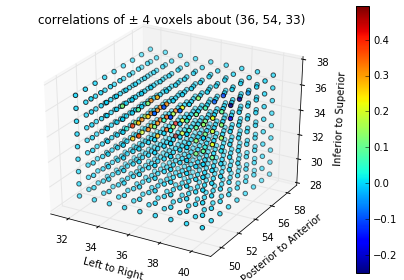

In [289]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
def get_4D_graph(best_thalamus_voxel, correlation_dict, sphere_size=4):
    epicenter = best_thalamus_voxel
    all_thalamus_voxels = []#list of lists, with each list being 3D coordinate in sphere
    for i in range(-sphere_size, sphere_size+1):
        for j in range(-sphere_size, sphere_size+1):
             for k in range(-sphere_size, sphere_size+1):
                    new_voxel = (epicenter[0]+i, epicenter[1]+j, epicenter[2]+k)
                    all_thalamus_voxels.append(new_voxel)
    c = []
    for thalamus_voxel in all_thalamus_voxels:
        try:
            c.append(correlation_dict[thalamus_voxel])
        except: #proposed voxel is not in correlation_dict
            c.append(0.0)
    all_thalamus_voxels_array = np.array(all_thalamus_voxels)
    x = all_thalamus_voxels_array[:,0]
    y = all_thalamus_voxels_array[:,1]
    z = all_thalamus_voxels_array[:,2]
    fig = plt.figure()
    from mpl_toolkits.mplot3d import Axes3D
    ax = fig.add_subplot(111, projection='3d')
    plt.title("correlations of ± " + str(sphere_size) + " voxels about " + str(epicenter))
    ax.set_xlabel('Left to Right')
    ax.set_ylabel('Posterior to Anterior')
    ax.set_zlabel('Inferior to Superior')
    sp = ax.scatter(x, y, z, c=c, depthshade=True)
    plt.colorbar(sp)
    fig.tight_layout()
    plt.savefig('output_4D.png', dpi=300)
get_4D_graph(best_thalamus_voxel, correlation_dict)

1


ValueError: x and y arrays must have a length of at least 3

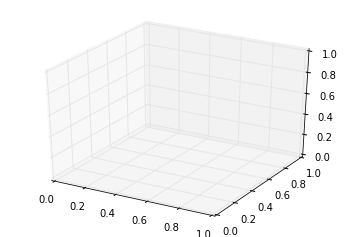

In [297]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

#f(2) --> 1 (2 - 1 = 1), 0 (2 - 2 = 0)
#f(1) --> 0 (1 - 1 = 0), 2 (1 - 2 = -1 = 2)
#f(0) --> 2 (0 - 1 = -1 = 2), 1 (0 - 2 = -2 = 1)

def get_volcano_graph(all_thalamus_voxels, best_thalamus_voxel, correlation_dict, flip=False, axis='z'):
    if axis == 'z':
        axis_num = 2
    elif axis == 'y':
        axis_num = 1
    elif axis == 'x':
        axis_num = 0
    else:
        raise NameError("Specify 'x', 'y', or 'z' for the fourth argument")
    
    z_plane = best_thalamus_voxel[axis_num]
    thalamus_voxels_on_plane = [voxel for voxel in all_thalamus_voxels if voxel[axis_num] == z_plane]
    thalamus_voxels_on_plane_array = np.array(thalamus_voxels_on_plane)
    x = thalamus_voxels_on_plane_array[:,axis_num-2]
    y = thalamus_voxels_on_plane_array[:,axis_num-1]
    z = []
    for thalamus_voxel in thalamus_voxels_on_plane:
        try:
            z.append(correlation_dict[thalamus_voxel])
        except: #proposed voxel is not in correlation_dict
            z.append(0.0)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    if flip:
        ax.plot_trisurf(y, x, z, cmap=cm.jet, linewidth=0.05)
    else:
        ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.05)
    title = "correlations of thalamus voxels at " + axis + "=" + str(best_thalamus_voxel[axis_num]) + " with max " +  str(best_thalamus_voxel)
    if flip:
        title += " flipped"
    plt.title(title)
    #ax.set_xlabel('Left to Right')
    #ax.set_ylabel('Posterior to Anterior')
    ax.set_zlabel('Correlation')
    plt.savefig(title + ".png", dpi=300)
    plt.show()

    
get_volcano_graph(thalamus_voxels, best_thalamus_voxel, correlation_dict, True, 'x')
get_volcano_graph(thalamus_voxels, best_thalamus_voxel, correlation_dict, False, 'x')
get_volcano_graph(thalamus_voxels, best_thalamus_voxel, correlation_dict, True, 'y')
get_volcano_graph(thalamus_voxels, best_thalamus_voxel, correlation_dict, False, 'y')
get_volcano_graph(thalamus_voxels, best_thalamus_voxel, correlation_dict, True, 'z')
get_volcano_graph(thalamus_voxels, best_thalamus_voxel, correlation_dict, False, 'z')